# Deep Learning - Project 2 - Convolutional Neural Networks


## Part 1 - Implementation of an image classifier

### 0) Imports

In [1]:
import os
import math
import numpy as np 
import time
from collections import Counter

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
%matplotlib inline 
from PIL import Image

from sklearn.model_selection import train_test_split
from tqdm import tqdm
from time import sleep
import json

In [2]:
import torch
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

print("Using torch", torch.__version__)

Using torch 1.12.1


In [3]:
# set seeds for reproducibility
torch.manual_seed(8)

if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")
print(device)

cuda


In [4]:
torch.cuda.empty_cache()

### 1) Download the data and load it in the Notebook

In [5]:
caltech_data = dset.Caltech101("data", target_type="category", download=True)
categories = caltech_data.categories

Files already downloaded and verified


Number of samples:  8677


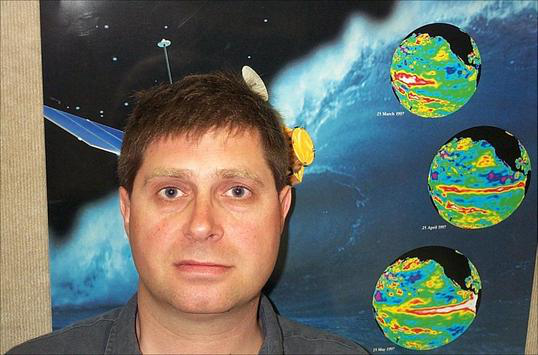

target: Faces, shape: (355, 538, 3)


In [6]:
print('Number of samples: ', len(caltech_data))
img, target = caltech_data[3] # fourth sample
display(img)
print(f"target: {categories[target]}, shape: {np.array(img).shape}")

### 2) Standardize the images

In [7]:
transform_img = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0)==1 else x) # unify number of channels
])

caltech_data = dset.Caltech101("data", transform=transform_img, target_type="category", download=True)

Files already downloaded and verified


In [8]:
def mean_std_max_min(loader):
    counter = 0
    ev = torch.empty(3)
    var = torch.empty(3)
    max_val = torch.empty(3)
    min_val = torch.empty(3)

    for images, _ in loader:
        b, c, h, w = images.shape
        number_of_pixels = b * h * w
        # sums over each channel
        sum_ = torch.sum(images, dim=[0, 2, 3])
        sum_of_square = torch.sum(images ** 2, dim=[0, 2, 3])
        # expected value
        ev = (counter * ev + sum_) / (counter + number_of_pixels)
        # variance
        var = (counter * var + sum_of_square) / (counter + number_of_pixels)
        # update max and min values
        max_values, _ = torch.max(images, dim=2)
        max_values, _ = torch.max(max_values, dim=2)
        max_values, _ = torch.max(max_values, dim=0)
        max_val, _  = torch.max(torch.stack((max_val, max_values)), dim=0)

        min_values, _ = torch.min(images, dim=2)
        min_values, _ = torch.min(min_values, dim=2)
        min_values, _ = torch.min(min_values, dim=0)
        min_val, _  = torch.min(torch.stack((min_val, min_values)), dim=0)
        
        counter += number_of_pixels

    mean, std = ev, torch.sqrt(var - ev ** 2)
    return mean, std, max_val, min_val

In [9]:
BATCH_SIZE = 4
image_data_loader = torch.utils.data.DataLoader(
  caltech_data, 
  batch_size = BATCH_SIZE, 
  shuffle=False,
  num_workers=0)

mean, std, max_val, min_val  = mean_std_max_min(image_data_loader)
print(f"Statistics of the whole dataset:\nmean = {mean}\nstd = {std}\nmax = {max_val}\nmin = {min_val}")

Statistics of the whole dataset:
mean = tensor([0.5390, 0.5173, 0.4887])
std = tensor([0.3056, 0.2996, 0.3121])
max = tensor([1., 1., 1.])
min = tensor([-0.0497,  0.0000, -0.0089])


In [10]:
# https://www.binarystudy.com/2022/04/how-to-normalize-image-dataset-inpytorch.html 
transform_standardization = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0)==1 else x), # unify number of channels
    transforms.Normalize(mean, std)
])

caltech_data = dset.Caltech101("data", transform=transform_standardization, target_type="category", download=True)

Files already downloaded and verified


In [11]:
# CHECK WHETHER mean == 0 and std == 1
image_data_loader_stand = torch.utils.data.DataLoader(
  caltech_data, 
  batch_size = BATCH_SIZE, 
  shuffle=False,
  num_workers=0)

mean, std, _, _ = mean_std_max_min(image_data_loader_stand)
print(f"Statistics of the whole dataset:\nmean = {mean}\nstd = {std}")
assert torch.le(mean.abs(), 0.001).all(), "Not all of the channels have mean equal to 0"
assert torch.isclose(std, torch.ones_like(std), atol=0.001).all(), "Not all of the channels have standard deviation equal to 1"

Statistics of the whole dataset:
mean = tensor([-4.4689e-07, -1.2186e-08,  8.0951e-07])
std = tensor([1.0000, 1.0000, 1.0000])


In [12]:
def display_img_tensor(img):
    images_np  = img.cpu().numpy()
    img_plt = images_np.transpose(1,2,0)
    plt.grid(False)
    plt.axis('off')
    plt.imshow(np.clip(img_plt, 0, 1))

target: Faces, shape: (3, 256, 256)


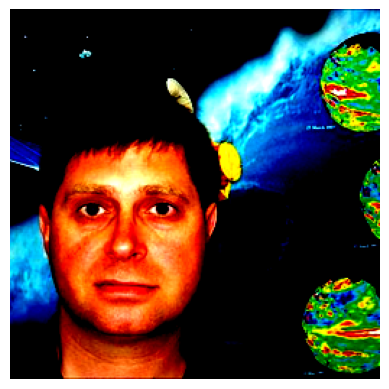

In [13]:
img, target = caltech_data[3]
display_img_tensor(img)
print(f"target: {categories[target]}, shape: {np.array(img).shape}")

### 3) Divide the collection into Train and Test set

In [14]:
# check the number of samples in each class
classes_count = dict(Counter(caltech_data.y))
classes_count = sorted(classes_count.items(), key=lambda item: item[1], reverse=True)
print("(id, number of samples)")
print(*classes_count[:35])

(id, number of samples)
(5, 800) (3, 798) (0, 435) (1, 435) (94, 239) (2, 200) (12, 128) (19, 123) (55, 114) (23, 107) (47, 100) (46, 99) (13, 98) (16, 91) (50, 88) (63, 87) (54, 86) (86, 86) (92, 86) (15, 85) (39, 85) (90, 85) (81, 84) (75, 82) (57, 81) (51, 80) (58, 78) (65, 76) (35, 75) (93, 75) (26, 73) (27, 70) (25, 69) (34, 68) (31, 67)


In [15]:
# take 20 classes with about 80 examples each
N_CLASSES = 20
chosen_classes = [item[0] for item in classes_count[12:12+N_CLASSES]]
res_list = map(categories.__getitem__, chosen_classes)
print("Selected classes:")
print(*res_list)

Selected classes:
brain butterfly helicopter menorah kangaroo starfish trilobite buddha ewer sunflower scorpion revolver laptop ibis llama minaret electric_guitar umbrella crab crayfish


In [16]:
idx, classes = [], []

for i, cl in enumerate(caltech_data.y):
    if cl in chosen_classes:
        idx.append(i)
        classes.append(cl)

In [17]:
# split
train_indices, test_indices = train_test_split(idx, test_size=0.3, stratify=classes)
len(train_indices), len(test_indices)

(1155, 496)

In [18]:
BATCH_SIZE = 4

train_set = torch.utils.data.Subset(caltech_data, train_indices)
test_set = torch.utils.data.Subset(caltech_data, test_indices)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE)

In [19]:
def check_sets(loader, show_idx=-1):
    stats_dict = dict()
    i = 0
    for images, labels in loader:
        for  img, lab in zip(images, labels):
          if i == show_idx:
              print('EXEMPLARY IMAGE')
              print(f'Label: {categories[lab]}')
              print(f'Shape: {img.shape}')
              display_img_tensor(img)
          i+=1
          if categories[lab] in stats_dict.keys():
            stats_dict[categories[lab]] += 1
          else:
            stats_dict[categories[lab]] = 1
    return stats_dict

EXEMPLARY IMAGE
Label: kangaroo
Shape: torch.Size([3, 256, 256])


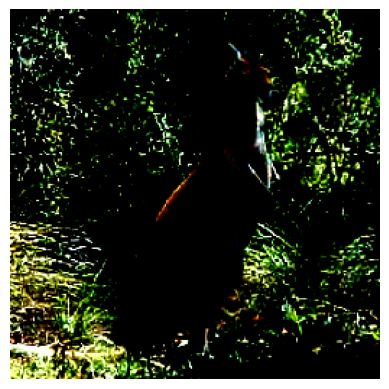

In [20]:
train_stats = check_sets(train_loader, show_idx=10)

EXEMPLARY IMAGE
Label: buddha
Shape: torch.Size([3, 256, 256])


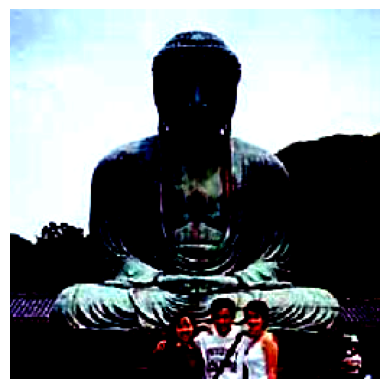

In [21]:
test_stats = check_sets(test_loader, show_idx=10)

In [22]:
assert train_stats.keys() == test_stats.keys()
denom_train = sum(train_stats.values()) # or alternatively len(train_indices)
denom_test = sum(test_stats.values())
print("CHECK CLASS PROPORTIONS IN BOTH SETS:")
for key in train_stats.keys():
    print(f'key: {str.upper(key)}\t\ttrain: {round(train_stats[key]/denom_train*100, 2)}%,\t\ttest: {round(test_stats[key]/denom_test*100,2)}%')

CHECK CLASS PROPORTIONS IN BOTH SETS:
key: BUTTERFLY		train: 5.54%,		test: 5.44%
key: ELECTRIC_GUITAR		train: 4.59%,		test: 4.44%
key: CRAB		train: 4.42%,		test: 4.44%
key: EWER		train: 5.11%,		test: 5.24%
key: BUDDHA		train: 5.11%,		test: 5.24%
key: HELICOPTER		train: 5.37%,		test: 5.24%
key: IBIS		train: 4.85%,		test: 4.84%
key: STARFISH		train: 5.19%,		test: 5.24%
key: KANGAROO		train: 5.19%,		test: 5.24%
key: LLAMA		train: 4.76%,		test: 4.64%
key: SUNFLOWER		train: 5.11%,		test: 5.24%
key: BRAIN		train: 5.97%,		test: 5.85%
key: MENORAH		train: 5.28%,		test: 5.24%
key: SCORPION		train: 5.11%,		test: 5.04%
key: CRAYFISH		train: 4.24%,		test: 4.23%
key: LAPTOP		train: 4.94%,		test: 4.84%
key: TRILOBITE		train: 5.19%,		test: 5.24%
key: REVOLVER		train: 4.94%,		test: 5.04%
key: UMBRELLA		train: 4.5%,		test: 4.64%
key: MINARET		train: 4.59%,		test: 4.64%


In [23]:
# ONE HOT ENCODING
def get_data_one_hot(train_indices, test_indices, caltech_data):
    x = torch.tensor([range(N_CLASSES)])
    one_hot_encoded = F.one_hot(x, num_classes=N_CLASSES)
    one_hot_encoded = torch.squeeze(one_hot_encoded)

    train_label_ids = list({caltech_data.y[i] for i in train_indices}) # list from the set of labels, hence can be either train_indices or test_indices
    temp_dict = dict(list(enumerate(train_label_ids)))
    temp_dict_reversed = dict()
    dict_new_label = dict()
    dict_old_label  = dict()

    for key, value in temp_dict.items():
        one_hot = tuple(one_hot_encoded[key].tolist())
        dict_old_label[one_hot] = value
        dict_new_label[value] = one_hot
        temp_dict_reversed[value] = key

    train_data_one_hot, test_data_one_hot, train_data, test_data = [], [], [], []
    for idx in train_indices:
        new_label_idx = temp_dict_reversed[caltech_data[idx][1]]
        train_data_one_hot.append([caltech_data[idx][0],one_hot_encoded[new_label_idx]])
        train_data.append([caltech_data[idx][0],new_label_idx])
    for idx in test_indices:
        new_label_idx = temp_dict_reversed[caltech_data[idx][1]]
        test_data_one_hot.append([caltech_data[idx][0],one_hot_encoded[new_label_idx]])
        test_data.append([caltech_data[idx][0],new_label_idx])
        
    return train_data_one_hot, test_data_one_hot, train_data, test_data, (dict_old_label, dict_new_label, temp_dict, temp_dict_reversed)

In [24]:
train_data_one_hot, test_data_one_hot, train_data, test_data, dicts = get_data_one_hot(train_indices, test_indices, caltech_data)

In [25]:
def get_label_from_tensor(tensor, dict_old_label, categories):
    key = tensor.tolist()
    if isinstance(key, list):
        key = tuple(key)
    return categories[dict_old_label[key]]

CATEGORY: CRAB
ID: 3
ONE HOT ENCODING: tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


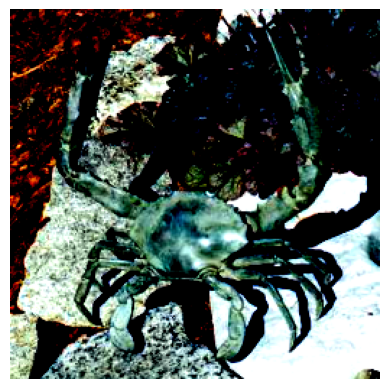

In [26]:
# CHECK TRAIN SET
x = 13
print(f'CATEGORY: {str.upper(get_label_from_tensor(train_data_one_hot[x][1], dicts[0], categories))}')
print(f'ID: {train_data[x][1]}\nONE HOT ENCODING: {train_data_one_hot[x][1]}')
display_img_tensor(train_data_one_hot[x][0])

CATEGORY: MINARET
ID: 13
ONE HOT ENCODING: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0])


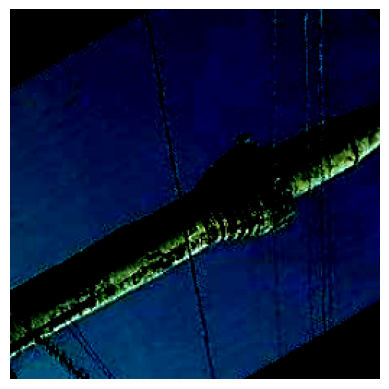

In [27]:
# CHECK TEST SET
x = 30
print(f'CATEGORY: {str.upper(get_label_from_tensor(test_data_one_hot[x][1], dicts[0], categories))}')
print(f'ID: {test_data[x][1]}\nONE HOT ENCODING: {test_data_one_hot[x][1]}')
display_img_tensor(test_data_one_hot[x][0])

### 4) Define the model 

In [28]:
class ConvModel(torch.nn.Module):
    def __init__(self, in_channels, num_of_classes, dropout_rate=0.5):
        super().__init__()

        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, 16, kernel_size=3, padding='same'),
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.Dropout2d(p=dropout_rate),
                        nn.MaxPool2d(2, 2))
        self.conv2 = nn.Sequential(
                        nn.Conv2d(16, 16, kernel_size=3, padding='same'),
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.Dropout2d(p=dropout_rate),
                        nn.MaxPool2d(2, 2))
        self.conv3 = nn.Sequential(
                        nn.Conv2d(16, 32, kernel_size=3, padding='same'),
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.Dropout2d(p=dropout_rate),
                        nn.MaxPool2d(2, 2))

        self.fc1 = nn.Linear(1024*32, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, num_of_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

There is no need to apply softmax in the archictecture, as PyTorch loss function `CrossEntropyLoss` already takes care of that. See https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html 

Propzycje:
- dropout_rate = 0.7

In [29]:
# changed internal parameters - still overfits 
class Model(nn.Module):
    def __init__(self, num_classes):
        super(Model, self).__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3,3), padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(0.25),
            nn.MaxPool2d(2,2)
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(0.25),
            nn.MaxPool2d(2,2)
        )
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout(0.25),
            nn.MaxPool2d(2,2)
        )
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128*8*8, 512)
        self.fc2 = nn.Linear(512, 256)
        self.out = nn.Linear(256, num_classes)
    
    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.out(x)
        return x

In [30]:
model = ConvModel(3, N_CLASSES)

# print(f"Model structure: {model}\n\n")
# for name, param in model.named_parameters():
#     print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

In [31]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-3)

In [32]:
model.to(device)

ConvModel(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout2d(p=0.5, inplace=False)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout2d(p=0.5, inplace=False)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout2d(p=0.5, inplace=False)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )


### 5) Train the model

In [33]:
BATCH_SIZE = 32

train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE)

In [34]:
class EarlyStopper:
    def __init__(self, patience, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.max_accuracy = -np.inf

    def early_stop(self, test_accuracy):
        if test_accuracy > self.max_accuracy:
            self.max_accuracy = test_accuracy
            self.counter = 0
        elif test_accuracy <= (self.max_accuracy + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [35]:
def train_model(model, optimizer, train_loader, test_loader, loss_module, epochs=250, batch_size=32, patience=5, verbose=True):
    model.train()
    train_accuracy_epochs = list()
    test_accuracy_epochs = list()
    train_loss_epochs = list()
    test_loss_epochs = list()

    early_stopper = EarlyStopper(patience=patience)
    for epoch in range(epochs):
        # TRAIN DATA
        model.train()
        mul = 1
        correct = 0
        train_loss = 0.0

        if verbose:
            tepoch = tqdm(train_loader, unit="batch")
        else:
                tepoch = train_loader

        for inputs, labels in tepoch:
            if verbose:
                tepoch.set_description(f"Epoch {epoch}")
            inputs, labels = inputs.to(device), labels.to(device)
                
            preds = model(inputs).squeeze(dim=1) # [BATCH_SIZE, 1], change it to [BATCH_SIZE]
            loss = loss_module(preds, labels)
            train_loss += loss

            pred_labels = torch.zeros(preds.shape)
            _, max_indices = preds.max(dim=1)
            for i in range(preds.size(0)):
                pred_labels[i][max_indices[i]] = 1
                
            pred_labels = pred_labels.to(device)
            # print(pred_labels)
            # print(labels)
            # print(sum([1 for tensor, pos in zip(pred_labels, labels) if tensor[pos.item()].item() == 1]))
            correct += sum([1 for tensor, pos in zip(pred_labels, labels) if tensor[pos.item()].item() == 1])
            train_accuracy = correct / (batch_size * mul)
            mul += 1 

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if verbose:
                tepoch.set_postfix(loss=loss.item(), train_accuracy=train_accuracy)
                
        train_accuracy_epochs.append(train_accuracy)
        # print((train_loss.cpu()/(mul-1)).item(), type((train_loss.cpu()/(mul-1)).item()))
        train_loss_epochs.append((train_loss.cpu()/(mul-1)).item())

        # TEST DATA
        model.eval()
        with torch.no_grad():
            mul = 1
            correct = 0
            test_loss = 0.0

            if verbose:
                ttest = tqdm(test_loader, unit="batch")
            else:
                ttest = test_loader

            for inputs, labels in ttest:
                if verbose:
                    ttest.set_description(f"Test set:")

                inputs, labels = inputs.to(device), labels.to(device)

                preds = model(inputs).squeeze(dim=1)
                loss = loss_module(preds, labels)
                test_loss += loss

                pred_labels = pred_labels = torch.zeros(preds.shape)
                _, max_indices = preds.max(dim=1)
                for i in range(preds.size(0)):
                        pred_labels[i][max_indices[i]] = 1

                pred_labels = pred_labels.to(device)
                correct += sum([1 for tensor, pos in zip(pred_labels, labels) if tensor[pos.item()].item() == 1])
                test_accuracy = correct / (batch_size * mul)
                mul += 1 

                if verbose:
                    ttest.set_postfix(loss=loss.item(), test_accuracy=test_accuracy)
            test_accuracy_epochs.append(test_accuracy)
            test_loss_epochs.append((test_loss.cpu()/(mul-1)).item())

            # EARLY STOPPING
            if early_stopper.early_stop(test_accuracy):             
                return train_accuracy_epochs, train_loss_epochs, test_accuracy_epochs, test_loss_epochs

    return train_accuracy_epochs, train_loss_epochs, test_accuracy_epochs, test_loss_epochs

In [36]:
EPOCHS = 250
train_accuracy, train_loss, test_accuracy, test_loss = train_model(model, optimizer, train_loader, test_loader, criterion, epochs=EPOCHS, patience=5)

Test set:: 100%|██████████| 16/16 [00:00<00:00, 45.64batch/s, loss=1.14, test_accuracy=0.521]


In [37]:
# SAVE TRAINING STATS - will be used later
def save_training_stats(keys, stats, file_path):
    stats_dict = dict([(k,s) for k,s in zip(keys, stats)])
    with open(file_path, 'w') as f:
        json.dump(stats_dict, f)

def load_training_stats(file_path):
    with open(file_path, 'r') as f:
        stats_dict = json.load(f)
    return stats_dict['train_accuracy'], stats_dict['test_accuracy'], stats_dict['train_loss'], stats_dict['test_loss']

In [38]:
# MOCKS - TO BE DELETED
# train_accuracy = [0.8, 0.9]
# test_accuracy = [0.76, 0.59]
# train_loss = [1.3, 1.1]
# test_loss = [1.4, 1.3]
keys = ['train_accuracy','test_accuracy','train_loss','test_loss']
stats = (train_accuracy,test_accuracy,train_loss,test_loss)
save_training_stats(keys, stats, 'stats/training_stats.json')

#### Model analysis

Learning curves

In [39]:
def visualize_stats(train_accuracy, train_loss, test_accuracy, test_loss, figsize=(17,7)):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    x = range(1, len(train_loss)+1)
    # ACCURACY
    ax1.plot(x, train_accuracy, label='train accuracy')
    ax1.plot(x, test_accuracy, label='test accuracy')
    ax1.set(xlabel='Epoch', xticks=range(1, len(train_loss)+1, 5), title='Accuracy learning curves')
    ax1.legend()
    # LOSS FUNCTION
    ax2.plot(x, train_loss, label='train loss')
    ax2.plot(x, test_loss, label='test loss')
    ax2.set(xlabel='Epoch', xticks=range(1, len(train_loss)+1, 5), title='Loss function learning curves')
    ax2.legend()
    plt.show()

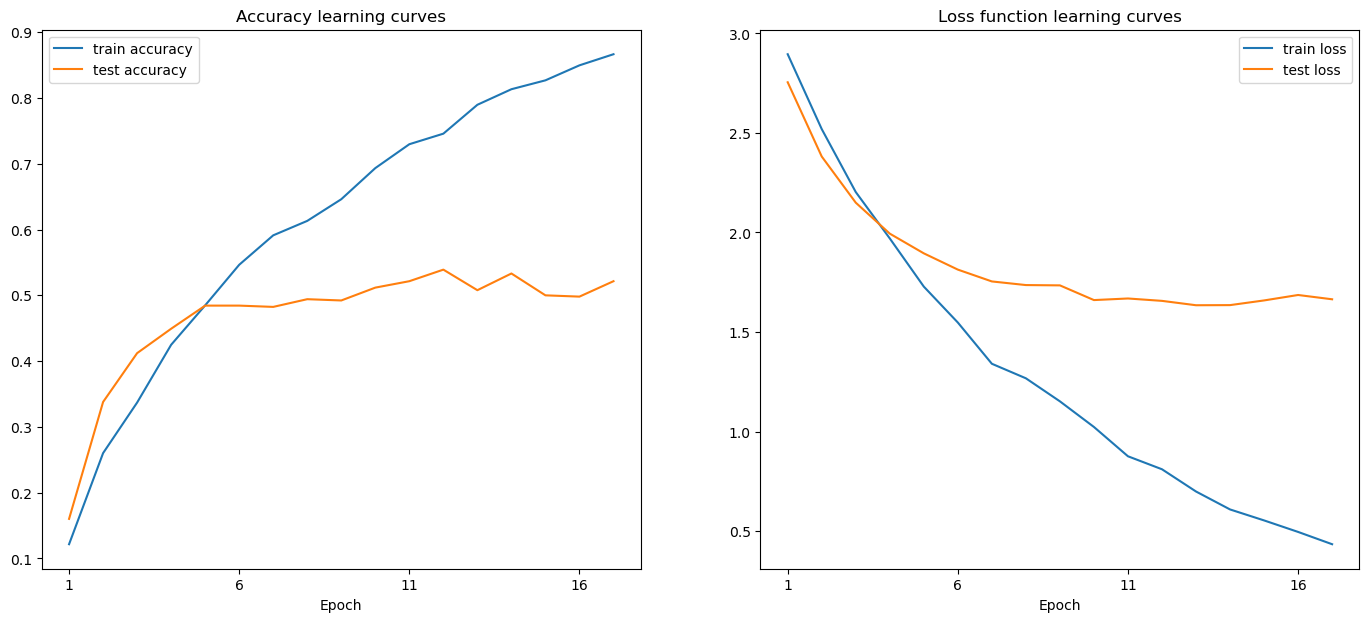

In [40]:
visualize_stats(train_accuracy, train_loss, test_accuracy, test_loss)

Confusion matrix for test data

In [41]:
def evaluate_model(model, data_loader, dict_old_label, categories):
    # device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    y_pred = []
    y_true = []
    model.eval()
    true_preds, num_preds = 0., 0.

    with torch.no_grad(): # Deactivate gradients for the following code
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            preds = model(inputs).squeeze(dim=1)

            pred_labels = torch.zeros(preds.shape)
            _, max_indices = preds.max(dim=1)
            for i in range(preds.size(0)):
                pred_labels[i][max_indices[i]] = 1
            
            # pred_labels = pred_labels.to(device)
            for pred, true in zip(max_indices, labels):
                y_pred.append(get_label_from_tensor(pred, dict_old_label, categories))
                y_true.append(get_label_from_tensor(true, dict_old_label, categories))
            
            # true_preds += torch.sum((pred_labels == labels)*(pred_labels == 1)).item()
            true_preds += sum([1 for tensor, pos in zip(pred_labels, labels) if tensor[pos.item()].item() == 1])
            num_preds += labels.shape[0]

    print(f'Accuracy of the model: {100.0*(true_preds/num_preds):4.2f}%')
    return y_pred, y_true

In [42]:
def get_confusion_matrix(y_true, y_pred):
    cf_matrix = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cf_matrix, display_labels=list(set(y_true)))
    fig, ax = plt.subplots(figsize=(10,10))
    disp.plot(ax=ax, xticks_rotation='vertical')
    disp.ax_.set(xlabel='Predicted', ylabel='True')
    ax.set_title('Confusion matrix', fontsize=20)
    plt.show()

Accuracy of the model: 53.83%


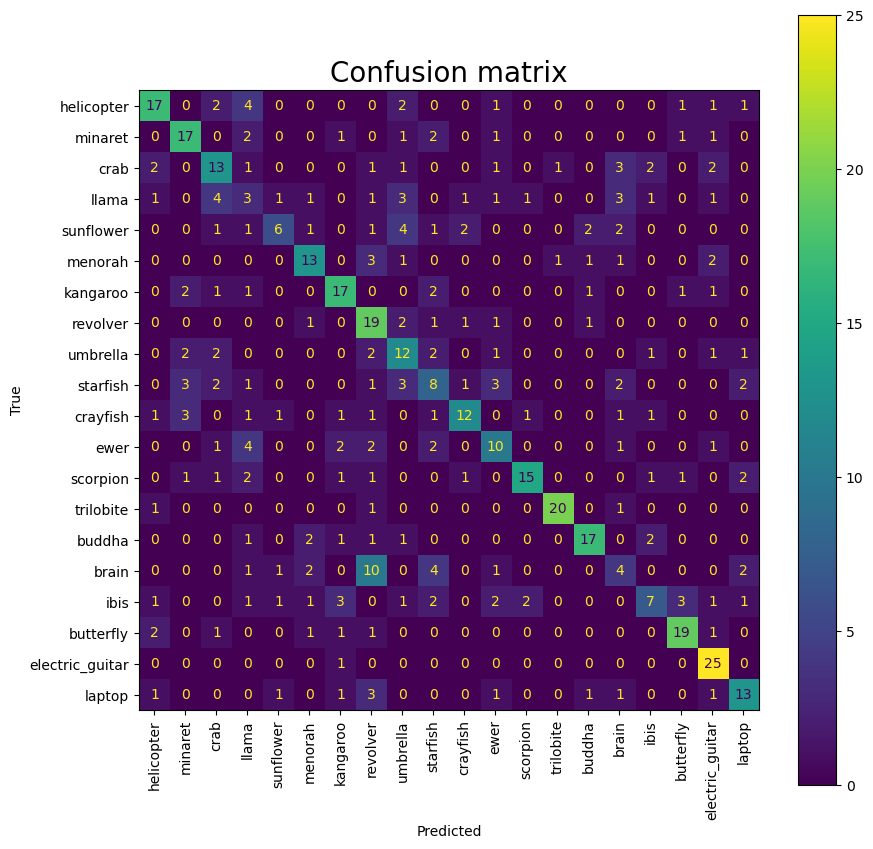

In [43]:
dict_old_label = dicts[2]
y_pred, y_true = evaluate_model(model, test_loader, dict_old_label, categories)
get_confusion_matrix(y_true, y_pred)

Precision and recall for each class

In [44]:
def precision_recall_classes(y_true, y_pred, verbose=True):
    labels_set = list(set(y_true))
    starting_dict = {'TP':0, 'FP':0, 'FN':0}
    temp = dict([(label,starting_dict.copy()) for label in labels_set])

    for pred, true in zip(y_pred, y_true):
        if pred == true:
            temp[pred]['TP'] += 1
        else:
            temp[true]['FN'] += 1
            temp[pred]['FP'] += 1
    stats = dict()
    for key, summary in temp.items():
        if (summary['TP']+summary['FP']) != 0:
            precision = summary['TP']/(summary['TP']+summary['FP'])
        else:
            precision = 0
        if (summary['TP']+summary['FN']) != 0:
            recall = summary['TP']/(summary['TP']+summary['FN'])
        else:
            recall = 0
        stats[key] = {'precision':precision, 'recall':recall}
        if verbose: 
            print(f'LABEL: {str.upper(key)}     \t\tprecision: {precision*100:3.2f}%, recall: {recall*100:3.2f}%')
    return stats


In [45]:
stats = precision_recall_classes(y_true, y_pred)

LABEL: HELICOPTER     		precision: 39.58%, recall: 73.08%
LABEL: MINARET     		precision: 90.91%, recall: 86.96%
LABEL: CRAB     		precision: 13.04%, recall: 13.64%
LABEL: LLAMA     		precision: 43.48%, recall: 43.48%
LABEL: SUNFLOWER     		precision: 73.08%, recall: 73.08%
LABEL: MENORAH     		precision: 78.95%, recall: 57.69%
LABEL: KANGAROO     		precision: 32.00%, recall: 30.77%
LABEL: REVOLVER     		precision: 73.91%, recall: 68.00%
LABEL: UMBRELLA     		precision: 59.09%, recall: 56.52%
LABEL: STARFISH     		precision: 46.67%, recall: 26.92%
LABEL: CRAYFISH     		precision: 54.55%, recall: 28.57%
LABEL: EWER     		precision: 58.62%, recall: 65.38%
LABEL: SCORPION     		precision: 21.05%, recall: 16.00%
LABEL: TRILOBITE     		precision: 65.79%, recall: 96.15%
LABEL: BUDDHA     		precision: 60.71%, recall: 65.38%
LABEL: BRAIN     		precision: 65.38%, recall: 58.62%
LABEL: IBIS     		precision: 38.71%, recall: 50.00%
LABEL: BUTTERFLY     		precision: 46.43%, recall: 48.15%
LABEL: EL

Exemplary predictions

In [46]:
def show_prediction(model, data, dict_tensor, dict_old_label, categories):
    input, label = data[0], data[1]
    model.eval()
    input = input[None, :]
    input = input.to(device)
    pred = model(input)
    pred = pred.squeeze(dim=0)
    print('PROBABILITIES:')
    print(pred.cpu().detach().numpy())
    
    pred_label = torch.zeros(pred.shape)
    _, max_idx = pred.max(dim=0)
    pred_label[max_idx] = 1
    pred_label = pred_label.squeeze(dim=0)

    print('\nPREDICTION:')
    print(f'{pred_label.cpu().detach().numpy()} -> {get_label_from_tensor(pred_label, dict_tensor, categories)}')
    print(f'TRUE CLASS: {categories[dict_old_label[label]]}')
    display_img_tensor(input[0])

PROBABILITIES:
[ 0.46109864  0.2648429   0.550797   -2.4555008  -0.88765484  0.23408014
 -0.2495264   1.1334405   0.84424716 -0.02263638  0.13113157  0.8672203
 -3.4744537   8.580513   -0.23811908  3.1596684   1.2880203  -3.101294
  1.8205736  -1.0773906 ]

PREDICTION:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.] -> minaret
TRUE CLASS: minaret


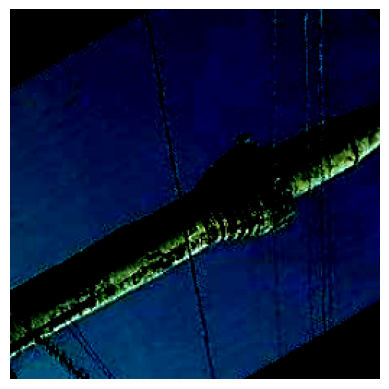

In [47]:
dict_old_lbl = dicts[0]
dict_tensor= dicts[2]

# CLASSIFIED CORRECTLY
x = 30
show_prediction(model, test_data[x], dict_old_lbl, dict_tensor, categories)

PROBABILITIES:
[-0.6634351  -1.7541897   0.18723732 -2.047073   -0.3303404   0.22447285
 -3.1346262   0.69542646  2.4191563   1.4799739  -0.66576934  3.007693
 -0.14134571  2.5071752   0.84621817  0.13237447  0.623192   -0.9335293
  0.00631214  1.129435  ]

PREDICTION:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.] -> llama
TRUE CLASS: llama


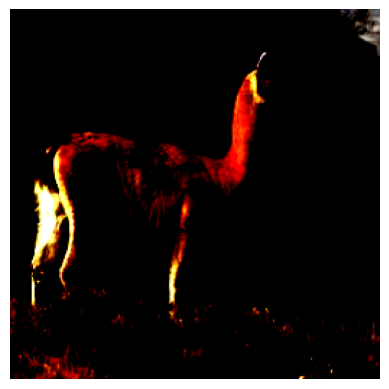

In [48]:
# CLASSIFIED INCORRECTLY
x = 20
show_prediction(model, test_data[x], dict_old_lbl, dict_tensor, categories)

### 6) Save the model to disk

In [49]:
# in Keras: https://machinelearningmastery.com/save-load-keras-deep-learning-models/
def save_model(model, path):
    torch.save(model.state_dict(), path)

def load_model(model_object, path):
    return model_object.load_state_dict(torch.load(path))

In [50]:
save_model(model, 'model/model.pth')
new_model = ConvModel(3, N_CLASSES)
load_model(new_model, 'model/model.pth')
new_model.to(device)

ConvModel(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout2d(p=0.5, inplace=False)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout2d(p=0.5, inplace=False)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout2d(p=0.5, inplace=False)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )


Check whether it works properly

Accuracy of the model: 53.83%


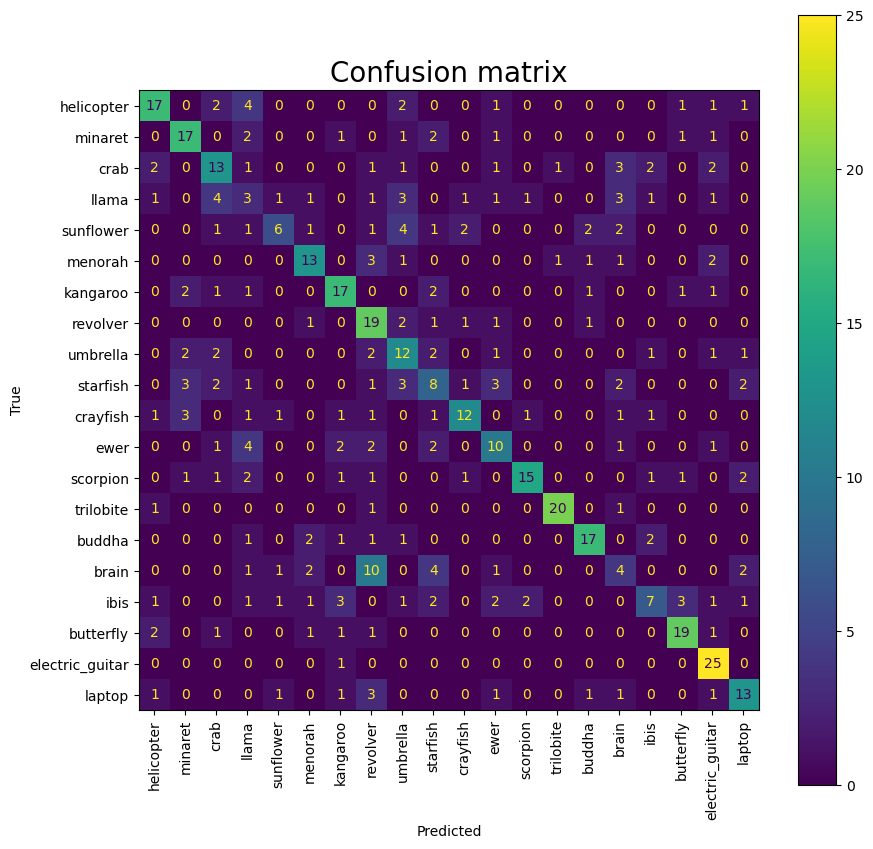

In [51]:
y_pred, y_true = evaluate_model(new_model, test_loader, dict_old_label, categories)
get_confusion_matrix(y_true, y_pred)

### 7) Summary of the Part 1 - describe your observations
    TODO (Agata)

Note: As we decided to try a new library for us (PyTorch), some steps have been modified in order to meet the criteria for the pipeline to work. 

## Part 2 - Experimental comparative analysis

### TASK 3: Compare the models without and with Dropout with different rates (e.g. 0.1, 0.2, 0.5)

Dropout rate = 0
Training time = 24.83s
Accuracy of the model: 57.66%


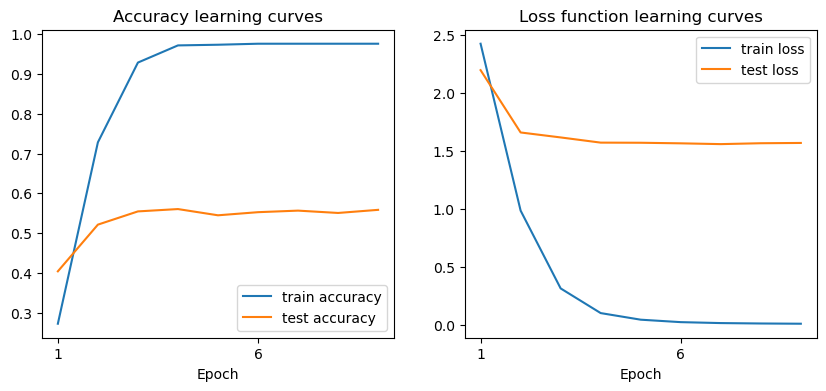

-------------------------------------------------------------
Dropout rate = 0.1
Training time = 29.31s
Accuracy of the model: 56.45%


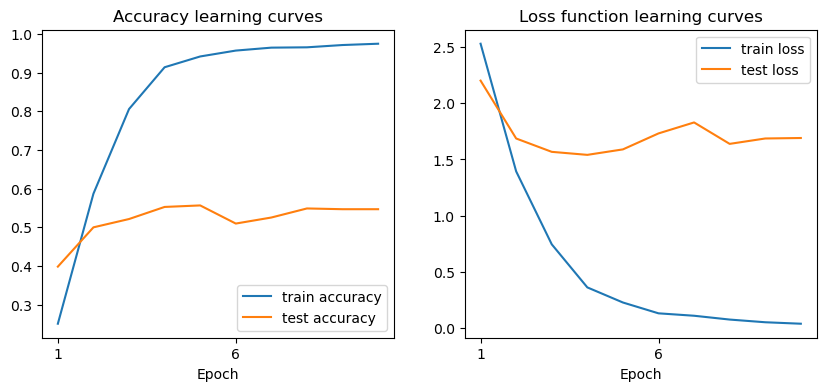

-------------------------------------------------------------
Dropout rate = 0.2
Training time = 41.18s
Accuracy of the model: 57.06%


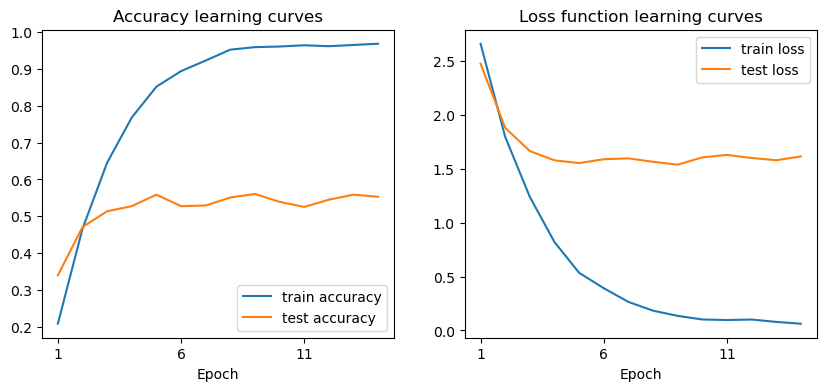

-------------------------------------------------------------
Dropout rate = 0.5
Training time = 55.86s
Accuracy of the model: 54.84%


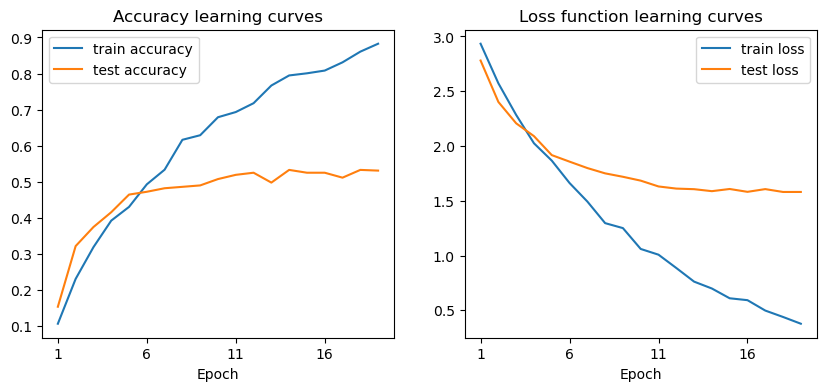

-------------------------------------------------------------
Dropout rate = 0.7
Training time = 58.79s
Accuracy of the model: 43.35%


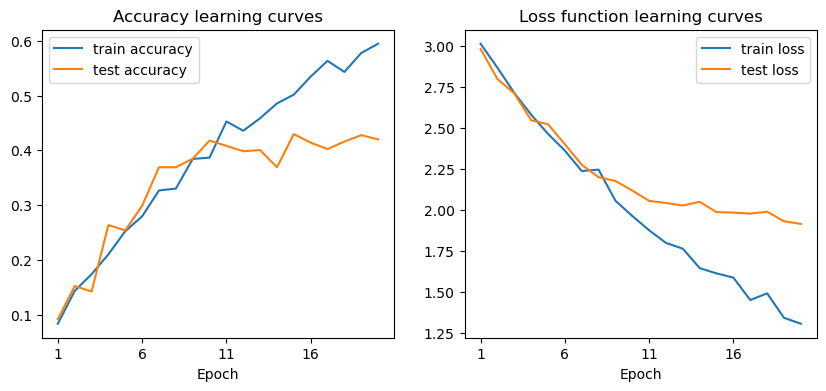

-------------------------------------------------------------


In [52]:
dropout_rates = [0, 0.1, 0.2, 0.5, 0.7]

for p in dropout_rates:
    print(f"Dropout rate = {p}")
    model = ConvModel(3, N_CLASSES, dropout_rate=p)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    model.to(device)

    training_start_time = time.time()
    train_accuracy, train_loss, test_accuracy, test_loss = train_model(model, optimizer, train_loader, test_loader, criterion, epochs=EPOCHS, patience=5, verbose=False)
    print(f"Training time = {time.time() - training_start_time:.2f}s")
    y_pred, y_true = evaluate_model(model, test_loader, dict_old_label, categories)
    visualize_stats(train_accuracy, train_loss, test_accuracy, test_loss, figsize=(10, 4))
    print("-------------------------------------------------------------")

#### Conclusions
Along with increasing dropout rate, accuracy decreases. However, with higher dropout rates, overfitting is smaller. The time of training is similar for every experiment.

Dropout rate = 0.5 seems to be the best choice, as it is compromise between highest accuracy and smallest overfitting.

### TASK 6: Compare the models for different preprocessing approaches <br>(perform operations separately per channel):
- Raw data - $X$
- Subtracting the mean ($X - \mu$)
- Normalization ($\frac{X - min}{max - min}$)
- Standardization ($\frac{X - \mu}{\sigma}$)

In [53]:
def evaluate_on_data(caltech_data, train_indices, test_indices, epochs=10):
    _, _, train_data, test_data, dicts = get_data_one_hot(train_indices, test_indices, caltech_data)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE)

    model = ConvModel(3, N_CLASSES)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-3)
    model.to(device)

    training_start_time = time.time()
    train_accuracy, train_loss, test_accuracy, test_loss = train_model(model, optimizer, train_loader, test_loader, criterion, epochs=epochs, patience=5, verbose=False)
    print(f"Training time = {time.time() - training_start_time:.2f}s")

    y_pred, y_true = evaluate_model(model, test_loader, dict_old_label, categories)
    visualize_stats(train_accuracy, train_loss, test_accuracy, test_loss, figsize=(10, 4))
    print("-------------------------------------------------------------")

RAW DATA:
Files already downloaded and verified
Training time = 30.03s
Accuracy of the model: 48.59%


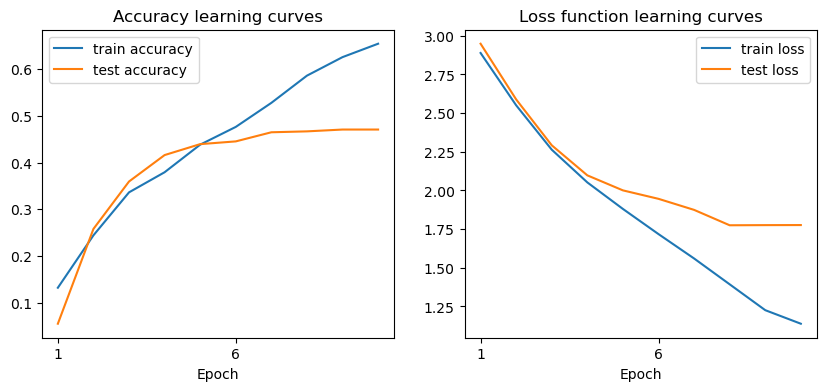

-------------------------------------------------------------
MEAN SUBSTRACTED:
Files already downloaded and verified
Training time = 29.82s
Accuracy of the model: 54.03%


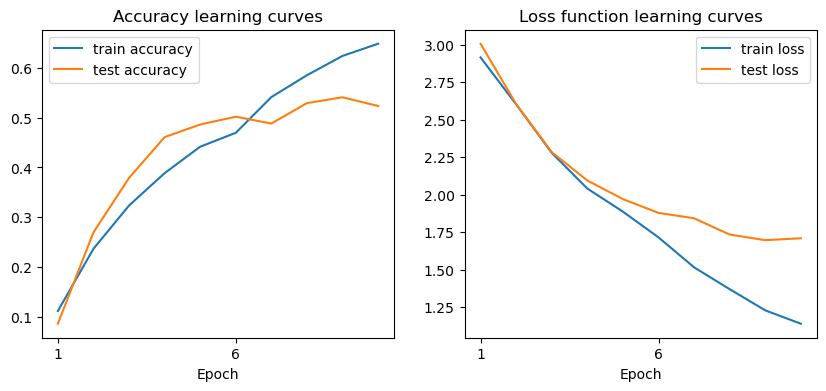

-------------------------------------------------------------
NORMALIZATION:
Files already downloaded and verified
Training time = 29.78s
Accuracy of the model: 51.81%


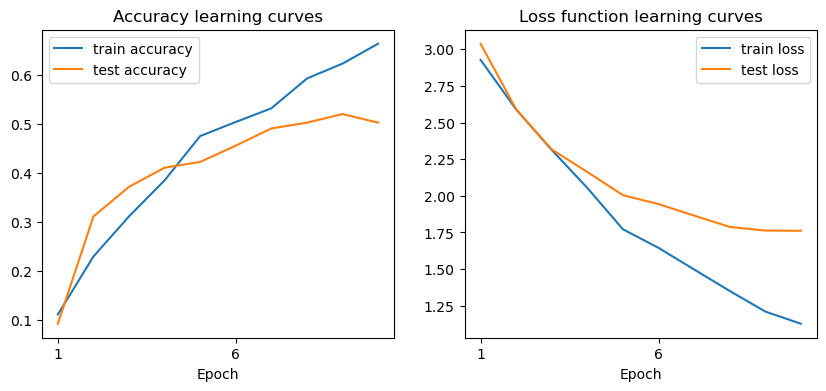

-------------------------------------------------------------
STANDARIZATION:
Accuracy of the model: 53.83%


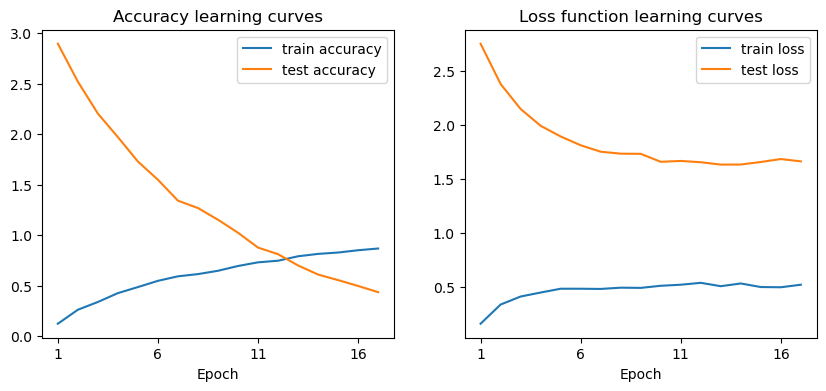

-------------------------------------------------------------


In [54]:
# RAW DATA (images are just cropped)
print("RAW DATA:")
caltech_data_raw = dset.Caltech101("data", transform=transform_img, target_type="category", download=True)
evaluate_on_data(caltech_data_raw, train_indices, test_indices)

# MEAN SUBSTRACTED
# mean -> calculated earlier
print("MEAN SUBSTRACTED:")
transform_mean = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0)==1 else x), # unify number of channels
    transforms.Normalize(mean, torch.ones(3))
])
caltech_data_mean = dset.Caltech101("data", transform=transform_mean, target_type="category", download=True)
evaluate_on_data(caltech_data_mean, train_indices, test_indices)

# NORMALIZATION
# max_val, min_val -> calculated earlier (the variables are used, although it is known the range is [0, 1])
print("NORMALIZATION:")
transform_norm = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0)==1 else x), # unify number of channels
    transforms.Normalize(min_val, (max_val- min_val))
])
caltech_data_norm = dset.Caltech101("data", transform=transform_norm, target_type="category", download=True)
evaluate_on_data(caltech_data_norm, train_indices, test_indices)

# STANDARIZATION (i.e. the main approach, therefore the model as well as the stats calculated during training are loaded from files)
print("STANDARIZATION:")
target_model = ConvModel(3, N_CLASSES)
load_model(target_model, 'model/model.pth')
target_model.to(device)
y_pred, y_true = evaluate_model(target_model, test_loader, dict_old_label, categories)
train_accuracy, train_loss, test_accuracy, test_loss = load_training_stats('stats/training_stats.json')
visualize_stats(train_accuracy, train_loss, test_accuracy, test_loss, figsize=(10, 4))
print("-------------------------------------------------------------")

#### Conclusions
    TODO (Agata)

### TASK 9: Compare the models with different number of Convolutional blocks

In [55]:
class ConvModel3(torch.nn.Module):
    def __init__(self, in_channels, num_of_classes, dropout_rate=0.5):
        super().__init__()

        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, 16, kernel_size=3, padding='same'),
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.Dropout2d(p=dropout_rate),
                        nn.MaxPool2d(2, 2))
        self.conv2 = nn.Sequential(
                        nn.Conv2d(16, 16, kernel_size=3, padding='same'),
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.Dropout2d(p=dropout_rate),
                        nn.MaxPool2d(2, 2))
        self.conv3 = nn.Sequential(
                        nn.Conv2d(16, 32, kernel_size=3, padding='same'),
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.Dropout2d(p=dropout_rate),
                        nn.MaxPool2d(2, 2))

        self.fc1 = nn.Linear(1024*32, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, num_of_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class ConvModel2(torch.nn.Module):
    def __init__(self, in_channels, num_of_classes, dropout_rate=0.5):
        super().__init__()

        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, 16, kernel_size=3, padding='same'),
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.Dropout2d(p=dropout_rate),
                        nn.MaxPool2d(2, 2))
        self.conv2 = nn.Sequential(
                        nn.Conv2d(16, 32, kernel_size=3, padding='same'),
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.Dropout2d(p=dropout_rate),
                        nn.MaxPool2d(2, 2))

        self.fc1 = nn.Linear(131072, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, num_of_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class ConvModel1(torch.nn.Module):
    def __init__(self, in_channels, num_of_classes, dropout_rate=0.5):
        super().__init__()

        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, 16, kernel_size=3, padding='same'),
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.Dropout2d(p=dropout_rate),
                        nn.MaxPool2d(2, 2))

        self.fc1 = nn.Linear(262144, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, num_of_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Model with 1 convolutional blocks
Training time = 111.57s
Accuracy of the model: 44.96%


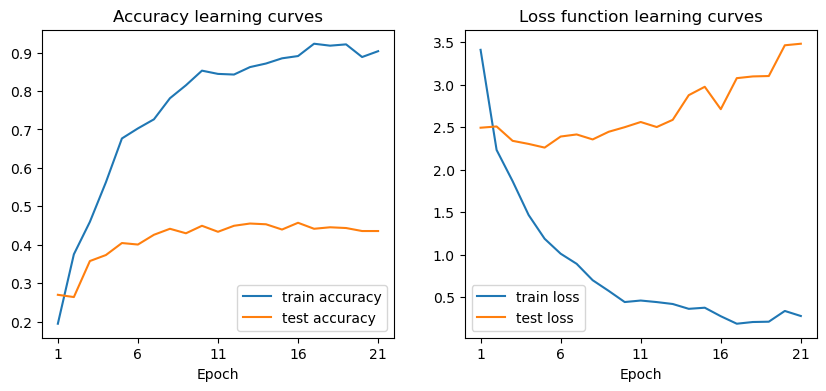

-------------------------------------------------------------
Model with 2 convolutional blocks
Training time = 79.01s
Accuracy of the model: 52.62%


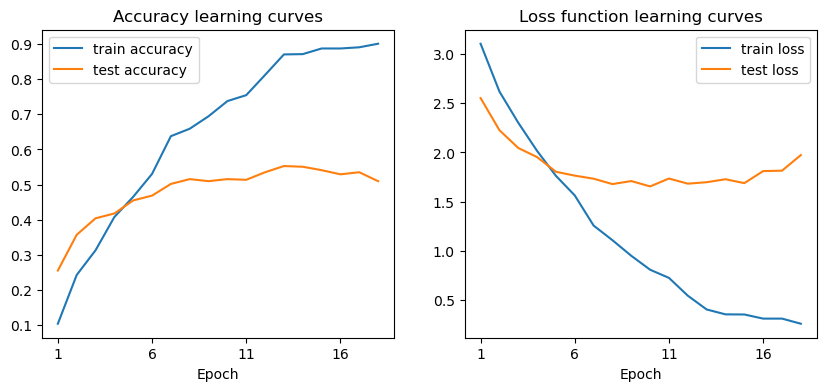

-------------------------------------------------------------
Model with 3 convolutional blocks
Training time = 70.60s
Accuracy of the model: 49.80%


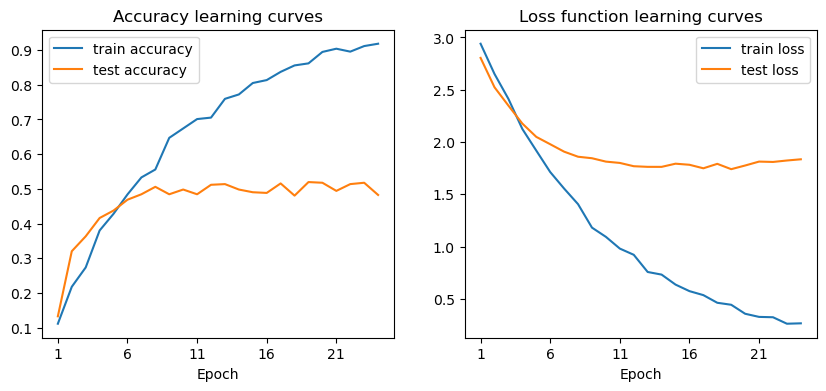

-------------------------------------------------------------


In [56]:
models = [ConvModel1(3, N_CLASSES), ConvModel2(3, N_CLASSES), ConvModel3(3, N_CLASSES)]

for i, model in enumerate(models):
    print(f"Model with {i+1} convolutional blocks")
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    model.to(device)

    training_start_time = time.time()
    train_accuracy, train_loss, test_accuracy, test_loss = train_model(model, optimizer, train_loader, test_loader, criterion, epochs=EPOCHS, patience=5, verbose=False)
    print(f"Training time = {time.time() - training_start_time:.2f}s")
    y_pred, y_true = evaluate_model(model, test_loader, dict_old_label, categories)
    visualize_stats(train_accuracy, train_loss, test_accuracy, test_loss, figsize=(10, 4))
    print("-------------------------------------------------------------")

#### Conclusions
With more convolutional blocks models are faster. Using just one block causes terrible overfit.

### TASK 11: Training with different batch sizes (e.g. 1, 16, 32, number_of_samples)

BATCH SIZE: 1
Training time = 201.42s
Accuracy of the model: 36.09%


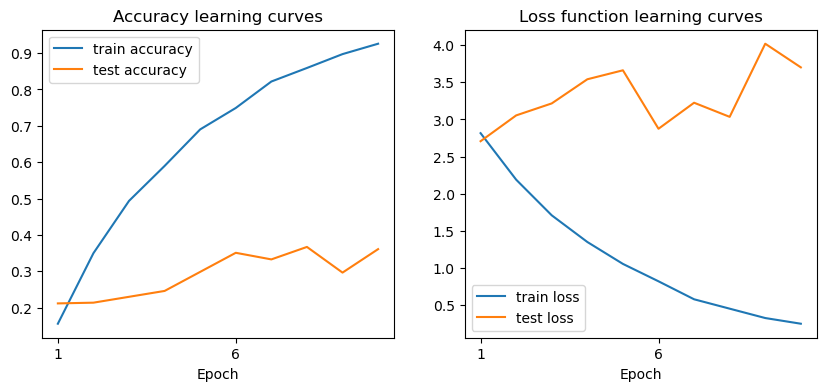

-------------------------------------------------------------
BATCH SIZE: 16
Training time = 34.95s
Accuracy of the model: 46.77%


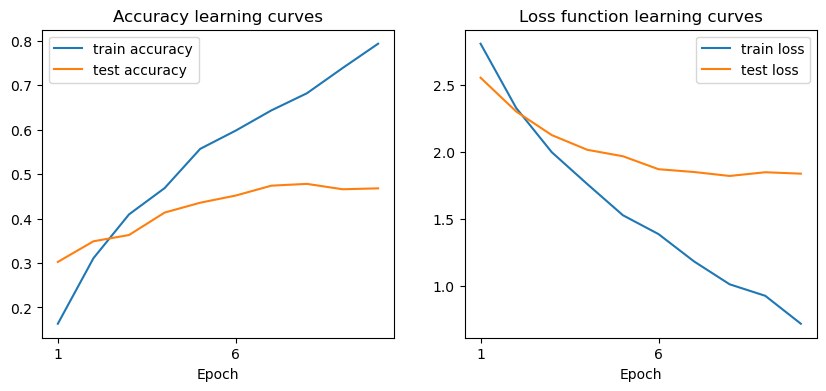

-------------------------------------------------------------
BATCH SIZE: 32
Training time = 29.82s
Accuracy of the model: 49.19%


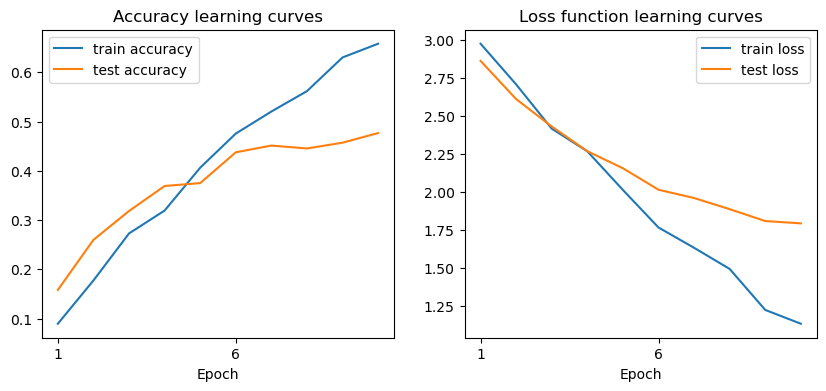

-------------------------------------------------------------
BATCH SIZE: 128
Training time = 26.37s
Accuracy of the model: 44.96%


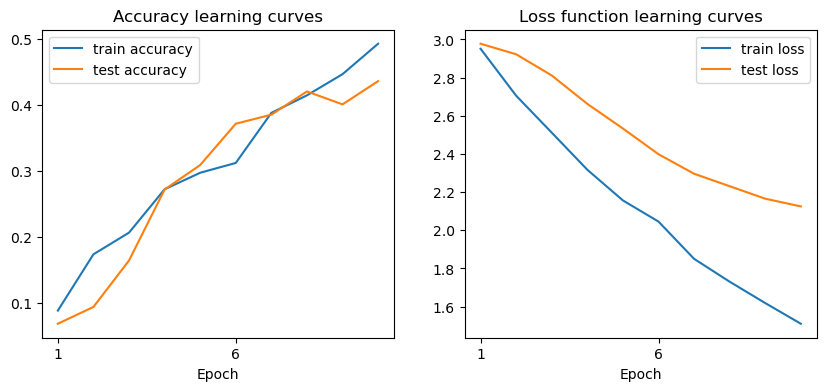

-------------------------------------------------------------


In [51]:
BATCH_SIZES = [1, 16, 32, 128] # drop_last == False as default so it will also work for the test loader
epochs = 10

for b in BATCH_SIZES:
    print(f'BATCH SIZE: {b}')
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=b)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=b)

    model = ConvModel(3, N_CLASSES)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-3)
    model.to(device)

    training_start_time = time.time()
    train_accuracy, train_loss, test_accuracy, test_loss = train_model(model, optimizer, train_loader, test_loader, criterion, epochs=epochs, batch_size=b, patience=5, verbose=False)
    print(f"Training time = {time.time() - training_start_time:.2f}s")

    y_pred, y_true = evaluate_model(model, test_loader, dict_old_label, categories)
    keys = ['train_accuracy','test_accuracy','train_loss','test_loss']
    stats = (train_accuracy,test_accuracy,train_loss,test_loss)
    save_training_stats(keys, stats, f'stats/training_stats_batch{b}.json')
    visualize_stats(train_accuracy, train_loss, test_accuracy, test_loss, figsize=(10, 4))
    print("-------------------------------------------------------------")

#### Conclusions
    TODO (Agata)